<a href="https://colab.research.google.com/github/jonzyyyy/AlphaLab/blob/main/AlphaLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup & Libraries

### Setting up necessary keys and env variables
(only required to run at the start of execution)

In [4]:
!pip install python-dotenv --quiet

from google.colab import drive
drive.mount('/content/drive')

# Copy Alpha Lab notebook to folder
!cp "/content/drive/MyDrive/Colab Notebooks/AlphaLab.ipynb" AlphaLab/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### GitHub Configurations

In [1]:
!git clone https://github.com/jonzyyyy/AlphaLab.git

Cloning into 'AlphaLab'...


In [15]:
!pip install yfinance --quiet
!pip install vectorbt --quiet
!pip install streamlit pyngrok --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import vectorbt as vbt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pyngrok import ngrok

This block of code below expects a secret that contains the necessary private API keys.

API Keys required:
1. NGROK

In [17]:
# !ngrok config add-authtoken NGROK_API_KEY
from google.colab import userdata
ngrok_token = userdata.get('NGROK_API_KEY')
ngrok.set_auth_token(ngrok_token)

In [ ]:
# Parameters
SPLIT_RATIO = 0.7
DATA_YEARS = 2
TOP_N_STOCKS = 5

# 2. Download S&P 500 Stocks List
For simplicity, we'll fetch the tickers from Wikipedia

In [ ]:
# Get S&P 500 tickers from Wikipedia
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(sp500_url)
sp500 = sp500_table[0]
tickers = sp500['Symbol'].tolist()

# We'll store market caps in a list of tuples
market_caps = []

for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get('marketCap', None)
        if cap is not None:
            market_caps.append((ticker, cap))
    except Exception as e:
        continue  # skip tickers with issues

# Convert to DataFrame
market_caps_df = pd.DataFrame(market_caps, columns=['Ticker', 'MarketCap'])

# Sort by market cap, descending
market_caps_df = market_caps_df.sort_values(by='MarketCap', ascending=False).reset_index(drop=True)

In [ ]:
print(market_caps_df.head(5))  # Show top 5 largest S&P 500 stocks
# (Optional) Use a smaller subset for a fast demo
tickers = market_caps_df['Ticker'][:25].tolist()  # Change to 50 or 100 if you want more
print(tickers)

  Ticker      MarketCap
0   NVDA  3972252565504
1   MSFT  3742358306816
2   AAPL  3153544871936
3   AMZN  2362573586432
4  GOOGL  2120181874688
['NVDA', 'MSFT', 'AAPL', 'AMZN', 'GOOGL', 'GOOG', 'META', 'AVGO', 'TSLA', 'JPM', 'WMT', 'LLY', 'V', 'ORCL', 'NFLX', 'MA', 'XOM', 'COST', 'JNJ', 'PG', 'HD', 'BAC', 'ABBV', 'PLTR', 'KO']


In [ ]:
# =======================
# 3. Download Price Data
# =======================
end = datetime.today()
start = end - timedelta(days=365*DATA_YEARS)  # Last 2 years
price_data = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True, progress=False)
print(price_data.head(3))

Ticker            TSLA                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2023-07-11  268.649994  270.899994  266.369995  269.790009   91972400   
2023-07-12  276.329987  276.519989  271.459991  271.989990   95672100   
2023-07-13  274.589996  279.450012  270.600006  277.899994  112681500   

Ticker             LLY                                               ...  \
Price             Open        High         Low       Close   Volume  ...   
Date                                                                 ...   
2023-07-11  443.627491  444.179558  431.412933  433.167755  3573100  ...   
2023-07-12  432.260724  438.008151  428.849730  434.360565  3107800  ...   
2023-07-13  433.995847  435.977362  428.189241  428.544159  2865100  ...   

Ticker           PLTR                                               ABBV  \
Price            Open       

In [ ]:
# =======================
# 4. Train-Test Split
# =======================
all_dates = price_data[tickers[0]]['Close'].index
split_idx = int(len(all_dates) * SPLIT_RATIO)
train_dates = all_dates[:split_idx]
test_dates = all_dates[split_idx:]

# Helper function to get price for a given ticker and period
def get_close_prices(ticker, dates):
    try:
        close = price_data[ticker]['Close'].reindex(dates)
        return close
    except:
        return pd.Series(index=dates, dtype=float)

In [ ]:
# =======================
# 5. Factor Calculation (Value, Momentum)
# =======================
factor_df = pd.DataFrame(index=tickers)

# Value factor: Trailing P/E (lower is "better")
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        factor_df.loc[ticker, 'pe_ratio'] = info.get('trailingPE', np.nan)
    except Exception:
        factor_df.loc[ticker, 'pe_ratio'] = np.nan

# Momentum factor: 6-month price return
for ticker in tickers:
    try:
        prices = price_data[ticker]['Close'].dropna()
        if len(prices) > 126:
            factor_df.loc[ticker, '6m_return'] = (prices.iloc[-1] / prices.iloc[-126]) - 1
        else:
            factor_df.loc[ticker, '6m_return'] = np.nan
    except Exception:
        factor_df.loc[ticker, '6m_return'] = np.nan

# Drop rows with missing factors
factor_df = factor_df.dropna()
print(factor_df.head(20))

         pe_ratio  6m_return
NVDA    52.711980   0.090185
MSFT    38.911130   0.181362
AAPL    32.684210  -0.136125
AMZN    35.720707  -0.022275
GOOGL   19.451542  -0.100739
GOOG    19.523077  -0.100444
META    28.173012   0.164704
AVGO    98.896800   0.181832
TSLA   169.074300  -0.280185
JPM     13.866797   0.188610
WMT     41.549360   0.064318
LLY     64.081436   0.032404
V       35.598010   0.146681
ORCL    54.334100   0.431823
NFLX    60.228146   0.460983
MA      39.380486   0.107262
XOM     15.153130   0.075510
COST    55.864050   0.066918
JNJ     17.325941   0.105955
PG      25.042927  -0.007046


In [ ]:
# =======================
# 6. Composite Scoring & Stock Selection
# =======================
# Rank: lower P/E is better, higher momentum is better
factor_df['pe_rank'] = factor_df['pe_ratio'].rank(ascending=True)
factor_df['mom_rank'] = factor_df['6m_return'].rank(ascending=False)
# Simple equal-weight composite score
factor_df['composite_score'] = (factor_df['pe_rank'] + factor_df['mom_rank']) / 2

# Select top N stocks
selected = factor_df.nsmallest(TOP_N_STOCKS, 'composite_score')
selected_tickers = selected.index.tolist()
print("Selected stocks for backtest:", selected_tickers)

Selected stocks for backtest: ['JPM', 'JNJ', 'META', 'XOM', 'KO']


In [ ]:
# 1. Find all trading days in your price data
all_dates = selected_prices_test.index

# 2. Set target rebalance dates (e.g., quarterly)
rebalance_targets = pd.date_range(start=all_dates[0], end=all_dates[-1], freq='QS')

# 3. Map each target rebalance date to the nearest available trading day ON OR AFTER the target
mapped_rebalance_dates = []
for target in rebalance_targets:
    candidates = all_dates[all_dates >= target]
    if not candidates.empty:
        mapped_rebalance_dates.append(candidates[0])
# Always include the very first day if it's not already in the list
if all_dates[0] not in mapped_rebalance_dates:
    mapped_rebalance_dates = [all_dates[0]] + mapped_rebalance_dates

print("Final mapped rebalance dates:", mapped_rebalance_dates)

# 4. Assign weights on these mapped rebalance dates
portfolio = pd.DataFrame(1 / len(selected_prices_test.columns), index=all_dates, columns=selected_prices_test.columns)
# print(portfolio.head(20))

# 5. Returns and cumulative returns
returns = selected_prices_test.pct_change().fillna(0)
portfolio_returns = (returns * portfolio).sum(axis=1)
print(portfolio_returns.head())
cum_returns = (1 + portfolio_returns).cumprod()
# print(portfolio_returns.head(20))

Final mapped rebalance dates: [Timestamp('2024-11-27 00:00:00'), Timestamp('2025-01-02 00:00:00'), Timestamp('2025-04-01 00:00:00'), Timestamp('2025-07-01 00:00:00')]
Date
2024-11-27    0.000000
2024-11-29    0.002173
2024-12-02    0.001867
2024-12-03    0.001996
2024-12-04   -0.013485
dtype: float64


<Figure size 1200x600 with 0 Axes>

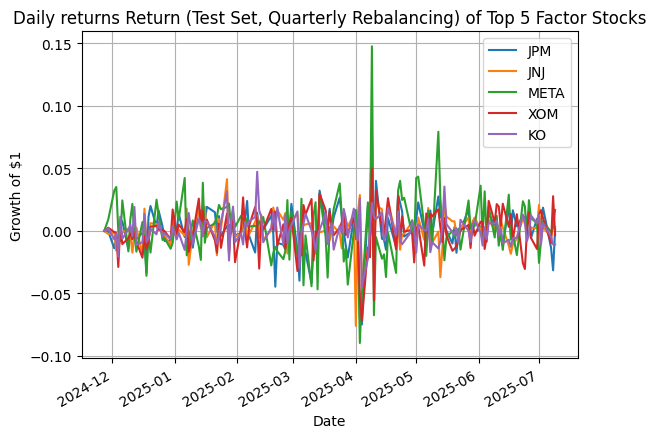

In [ ]:
# =======================
# 8a. Results Visualization
# =======================
plt.figure(figsize=(12,6))
returns.plot()
plt.title('Daily returns Return (Test Set, Quarterly Rebalancing) of Top 5 Factor Stocks')
plt.ylabel('Growth of $1')
plt.xlabel('Date')
plt.grid()
plt.show()

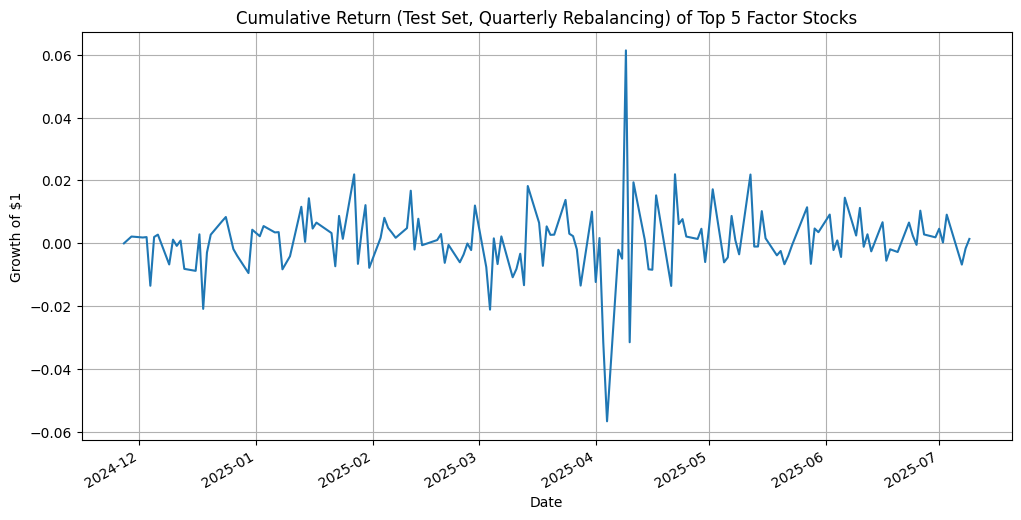

In [ ]:
# =======================
# 8b. cum_returns Results Visualization
# =======================
plt.figure(figsize=(12,6))
portfolio_returns.plot()
plt.title('Cumulative Return (Test Set, Quarterly Rebalancing) of Top 5 Factor Stocks')
plt.ylabel('Growth of $1')
plt.xlabel('Date')
plt.grid()
plt.show()

In [ ]:
# =======================
# 9. Simple Performance Stats
# =======================
total_return = cum_returns[-1] - 1
annualized_return = cum_returns[-1]**(252/len(cum_returns)) - 1
annualized_vol = portfolio_returns.std() * np.sqrt(252)
sharpe = annualized_return / annualized_vol

print(f"Total Return (Test): {total_return:.2%}")
print(f"Annualized Return (Test): {annualized_return:.2%}")
print(f"Annualized Volatility (Test): {annualized_vol:.2%}")
print(f"Sharpe Ratio (Test): {sharpe:.2f}")

Total Return (Test): 12.12%
Annualized Return (Test): 21.03%
Annualized Volatility (Test): 17.38%
Sharpe Ratio (Test): 1.21


/tmp/ipython-input-28-1262638307.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = cum_returns[-1] - 1
/tmp/ipython-input-28-1262638307.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized_return = cum_returns[-1]**(252/len(cum_returns)) - 1


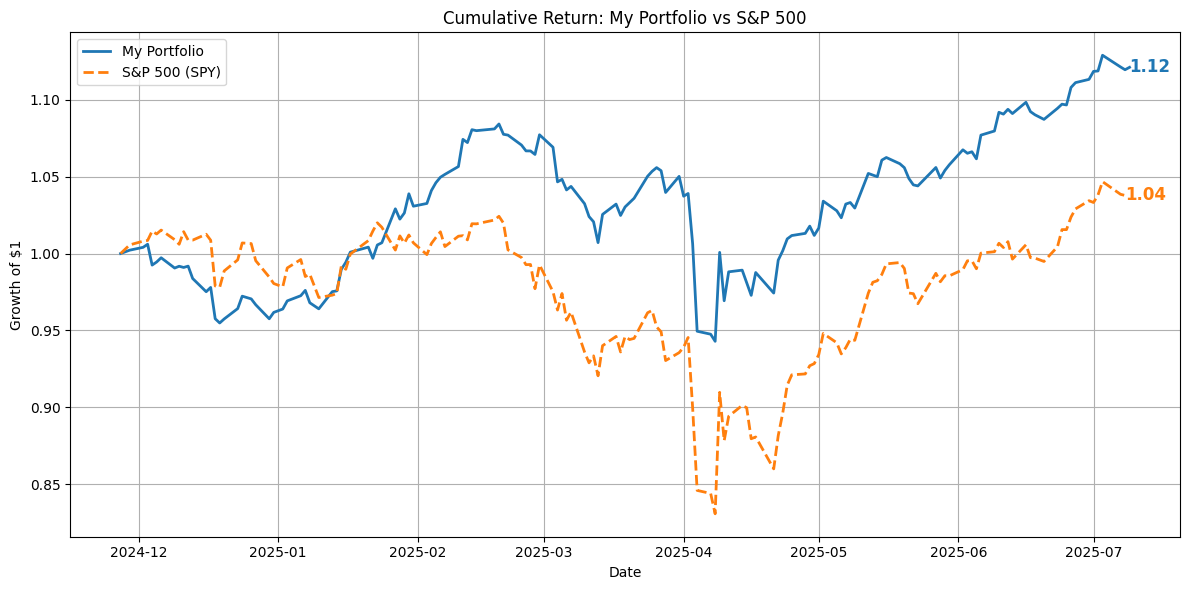

In [ ]:
# =======================
# 8. Results Visualization (with Benchmark)
# =======================

# 1. Download S&P 500 (SPY) data for the test period
spy_ticker = '^GSPC' # or 'SPY' for the ETF
spy_data = yf.download(spy_ticker, start=test_dates[0], end=test_dates[-1], auto_adjust=True, progress=False)
spy_close_prices = spy_data['Close']

# 2. Calculate SPY's daily returns and cumulative returns
benchmark_returns = spy_close_prices.pct_change().fillna(0)
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

# 3. Plot both on the same graph
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot your portfolio
plt.plot(cum_returns.index, cum_returns.values,
         label='My Portfolio', linewidth=2)

# Plot the benchmark
plt.plot(benchmark_cum_returns.index, benchmark_cum_returns.values,
         linestyle='--', label='S&P 500 (SPY)', linewidth=2)

# Annotate final values
last_date = cum_returns.index[-1]
last_value = cum_returns.values[-1]
bench_last_value = benchmark_cum_returns.values[-1]

plt.text(last_date, last_value,
         f"{last_value:.2f}",
         color='C0', fontsize=12, va='center', ha='left', fontweight='bold')

plt.text(benchmark_cum_returns.index[-1], bench_last_value,
         f"{bench_last_value:.2f}",
         color='C1', fontsize=12, va='center', ha='left', fontweight='bold')

plt.title('Cumulative Return: My Portfolio vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Write a simple Streamlit app
with open('app.py', 'w') as f:
    f.write("""
import streamlit as st
st.title('Hello Streamlit via ngrok!')
st.write('It works in Colab!')
""")

# Open the tunnel
public_url = ngrok.connect(8501)
print("Public URL:", public_url)

# Run Streamlit
!streamlit run app.py &>/dev/null&

Public URL: NgrokTunnel: "https://448454a0576d.ngrok-free.app" -> "http://localhost:8501"
